In [32]:
from string import digits
from sklearn.base import BaseEstimator, TransformerMixin
import re
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

hp_pattern = r'(\d+\.?\d*)(\s*hp)'      

liters_pattern = r'(\d+\.?\d*)(\s*l)'     
liters_pattern_full = r'(\d+\.?\d*\s*liter)' 

cylinder_pattern = r'(\d+)\s*cylinder'
cylinder_pattern_letter = r'v|h|w|i-?(\d)'
cylinder_pattern_flat = r'flat\s(\d)'

fuel_list_engine = ["plug-in", "diesel", "hybrid", "gdi", "pdi", "gasoline", 
                    "electric", "hydrogen", "flexible", "flex"]

fuel_list_dict= {"plug-in": "plug-in hybrid",
                 "gdi": "gasoline",
                 "pdi": "diesel",
                 "flexible": "flex",
                 "e85 flex fuel": "flex"}

fuel_list = ["plug-in hybrid", "hybrid", "gasoline",
             "diesel", "flex", "electric", "hydrogen"]

def extract_gears(transmission):
    match = re.search(r'(\d+)-?speed', transmission, re.IGNORECASE)
    if match:
        return int(match.group(1))
    else:
        return 6

def is_manual_or_automatic(transmission):
    if "m/t" in transmission.lower() or "manual" in transmission.lower():
        return "manual"
    elif "automatic" in transmission.lower() or "a/t" in transmission.lower() or "cvt" in transmission.lower():
        return "automatic"
    else:
        return "other" 

def remove_numbers_from_string(s):
    result = ''.join([i for i in s if not i.isdigit()])
    result = ''.join([i for i in result if not i == "."])

    return result

def fuel_parser(s):
    for fuel in fuel_list:

        if fuel in s:
            return fuel
        
    for fuel in fuel_list_engine:
        if fuel in s:
            return fuel_list_dict[fuel]
    
    return pd.NA

def extract_engine_info(engine_str):
    hp = re.search(hp_pattern, engine_str)
    
    liters = re.search(liters_pattern, engine_str)
    if not liters:
        liters = re.search(liters_pattern_full, engine_str)
        
    cylinders_str = False    
    cylinders = re.search(cylinder_pattern, engine_str)
    if not cylinders:
        cylinders = re.search(cylinder_pattern_letter, engine_str)
        if not cylinders:
            cylinders = re.search(cylinder_pattern_flat, engine_str)
    
    return {
        'power(HP)': float(hp.group(1)) if hp else pd.NA,
        'displacement(L)': float(liters.group(1)) if liters else pd.NA,
        'n_cylinders': float(cylinders_str) if cylinders else pd.NA,
    }

def estimate_cylinders(engine_string):
    if "turbo" in engine_string:
        return 4  # Muchos motores turbo son I4 o V6
    else:
        return 6  

def estimate_displacement(engine_string, cylinders):
    if "turbo" in engine_string:
                return 2.0  # Motores turbo tienden a ser más pequeños
    if cylinders == 4:
        return 2.5
    if cylinders == 6:
        return 3.5
    if cylinders in [8,10,12,14,16]:
        return 5
    
    return 3

def estimate_horsepower(engine_str, cylinders):
    if cylinders == 8:
        if 'Turbo' in engine_str:
            return (400 + 500) / 2  
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (350 + 450) / 2  
        else:
            return (300 + 400) / 2
    elif cylinders == 6:
        if 'Turbo' in engine_str:
            return (300 + 400) / 2 
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (250 + 350) / 2 
        else:
            return (200 + 300) / 2
    elif cylinders == 4:
        if 'Turbo' in engine_str:
            return (200 + 300) / 2
        elif 'GDI' in engine_str or 'MPFI' in engine_str or 'DOHC' in engine_str:
            return (150 + 250) / 2 
        else:
            return (100 + 200) / 2 
    elif cylinders == 10:
        if 'Turbo' in engine_str:
            return (600 + 800) / 2
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (500 + 600) / 2  
        else:
            return (400 + 600) / 2 
    elif cylinders == 12:
        if 'Turbo' in engine_str:
            return (700 + 900) / 2 
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (600 + 800) / 2  
        else:
            return (500 + 700) / 2 
    elif 'OHV' in engine_str:
        return (200 + 300) / 2 
    else:
        return pd.NA
    
class EngineParser(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X["fuel_type_engine"] = X["engine"].apply(lambda x: fuel_parser(x) if type(x) == str else x)
        X["fuel_type"] = X["fuel_type"].apply(lambda x: fuel_parser(x) if type(x) == str else x)
        condition = (X["fuel_type"] != X["fuel_type_engine"]) & (~X["fuel_type_engine"].isna())
        X.loc[condition, "fuel_type"] = X["fuel_type_engine"]
        X = X.drop(columns = ["fuel_type_engine"])

        engine_info_dicts = X["engine"].apply(extract_engine_info)
        new_features = pd.DataFrame(list(engine_info_dicts))
        X["power(HP)"] = new_features["power(HP)"]
        X["displacement(L)"] = new_features["displacement(L)"]
        X["n_cylinders"] = new_features["n_cylinders"]
        
        X.loc[(X["displacement(L)"].isna()) & (X["fuel_type"] == "electric"),
        "displacement(L)"] = 0
        X.loc[X["fuel_type"].isna(), "fuel_type"] = "gasoline"
        X.loc[(X["n_cylinders"].isna()) & (X["fuel_type"] == "hybrid"),
        "n_cylinders"] = 4
        
        estimated_cylinders = X["engine"][X["n_cylinders"].isna()].apply(estimate_cylinders)
        X.loc[X["n_cylinders"].isna(), "n_cylinders"] = estimated_cylinders

        estimated_displacement = X[X["displacement(L)"].isna()].apply(lambda row: estimate_displacement(row['engine'], 
                                                                row['n_cylinders']), axis=1)
        X.loc[X["displacement(L)"].isna(), "displacement(L)"] = estimated_displacement

        estimated_hp = X[X["power(HP)"].isna()].apply(lambda row: estimate_displacement(row['engine'], 
                                                                row['n_cylinders']), axis=1)
        X.loc[X["power(HP)"].isna(), "power(HP)"] = estimated_hp
        
        X.drop(columns = "engine", inplace= True)
        
        X["power(HP)"] = pd.to_numeric(X["power(HP)"])
        
        return X
        
        
class StringLower(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.applymap(lambda s: s.lower() if type(s) == str else s)
        return X
    
def custom_rmse(y_true, y_pred):
    y_true_transformed = np.power(y_true, 2) 
    y_pred_transformed = np.power(y_pred, 2) 
    return mean_squared_error(y_true_transformed, y_pred_transformed, squared=False)

rmse_scorer = make_scorer(custom_rmse, greater_is_better=False)

In [45]:
import difflib

df = pd.read_csv("data/train-2.csv")

#df["price"] = np.log1p(df[["price"]])
df['price'] = -np.log1p(df['price']) 

df["age"] = 2025 - df["model_year"]
df["use"] = df["milage"]/df["age"]
df.drop(columns = ["model_year", "clean_title"], inplace= True)

string_lower = StringLower()
engine_parser = EngineParser()

df = string_lower.transform(df)
df = engine_parser.transform(df)

df.loc[(df["power(HP)"]>1000) & (df["brand"].str.contains("ford")), "power(HP)"] = 480

df['num_gears'] = df['transmission'].apply(extract_gears)
df['transmission_type'] = df['transmission'].apply(is_manual_or_automatic)
df.drop(columns = ["transmission"], inplace = True)

grouped_by_mean = df.groupby(['int_col']).mean()['price']
lux_int_col = grouped_by_mean.sort_values(ascending= False).nlargest(20).index.to_list()
df['lux_int_col'] = df["int_col"].isin(lux_int_col).apply(int)
df.drop(columns = ["int_col"], inplace= True)

grouped_by_mean_ext = df.groupby('ext_col')['price'].mean()
col_bins = [0, 80000, 150000, float('inf')]
col_labels = ['normal', 'top', 'luxury']
grouped_by_mean_ext_bins = pd.cut(grouped_by_mean_ext, bins=col_bins, labels=col_labels, right=True)
grouped_colors = pd.DataFrame({'mean_price': grouped_by_mean_ext, 'ext_col_bins': grouped_by_mean_ext_bins})
df['ext_col_bins'] = df['ext_col'].map(grouped_colors['ext_col_bins'])

numeric_features = ['milage', 'age', 'power(HP)', 'n_cylinders',
                    'displacement(L)', "use", 'num_gears']
categorical_features = ['brand', 'model', 'fuel_type', 'ext_col_bins',
                        'accident', 'transmission_type', 'lux_int_col'] 

df[numeric_features] = df[numeric_features].astype("float32")
df[categorical_features] = df[categorical_features].astype("category")

X = df.drop(columns = ['price','id'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

# 4. Crear preprocesador
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())])  

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

model = lgb.LGBMRegressor(objective='regression',
    boosting_type='gbdt',  
    n_estimators=400,  
    learning_rate=0.05,  
    num_leaves=100,  
    random_state=42,
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

cv_results = cross_validate(
    pipeline, 
    X_train, 
    y_train, 
    cv=10, 
    scoring=rmse_scorer,
    return_train_score=True 
)

print(f"RMSE promedio en validación cruzada: {-np.mean(cv_results['test_score'])}")
pipeline.fit(X_train, y_train)

log_test_predictions = pipeline.predict(X_test)
test_predictions = np.exp(-log_test_predictions) - 1
test_rmse = mean_squared_error(np.expm1(y_test), test_predictions, squared=False)

print(test_rmse)

/var/folders/4w/r3wqy9sx29x_q3nlp7zqhv480000gn/T/ipykernel_29736/623244108.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_mean = df.groupby(['int_col']).mean()['price']


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 118775, number of used features: 13
[LightGBM] [Info] Start training from score -10.291376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1173
[LightGBM] [Info] Number of data points in the train set: 118775, number of used features: 13
[LightGBM] [Info] Start training from score -10.290240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

Index(['brand', 'model', 'milage', 'fuel_type', 'ext_col', 'accident', 'age',
       'use', 'power(HP)', 'displacement(L)', 'n_cylinders', 'num_gears',
       'transmission_type', 'lux_int_col', 'ext_col_bins'],
      dtype='object')


NameError: name 'feature_names' is not defined

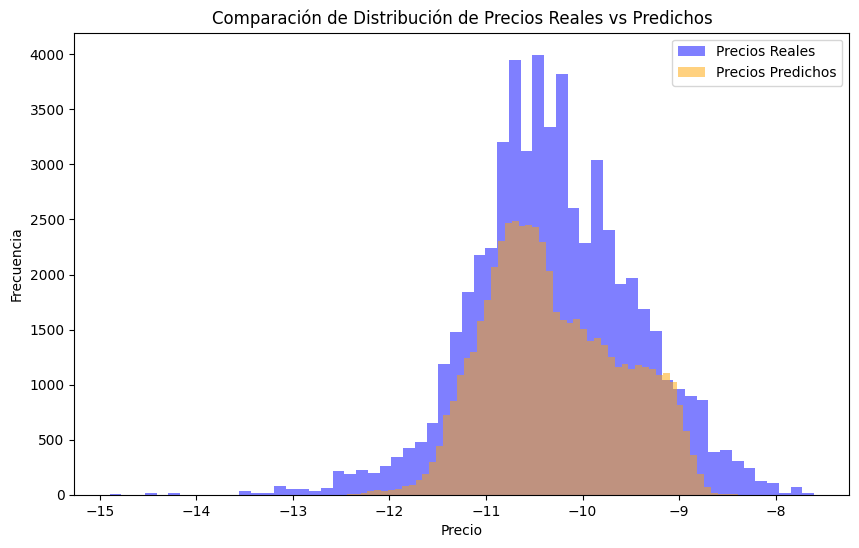

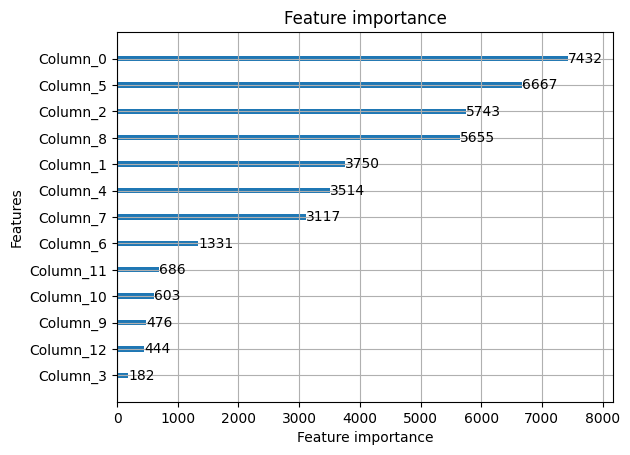

In [47]:
import seaborn as sns
def plot_model_feature_importance(model, X_train):
    
    print(X_train.columns)
    
    feature_importance = model.feature_importances_

    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

    importance_df = importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
    plt.xlabel('Importancia')
    plt.title('Importancia de Características en LightGBM')
    plt.gca().invert_yaxis()
    plt.show()

plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=60, alpha=0.5, label='Precios Reales', color='blue')
plt.hist(log_test_predictions, bins=60, alpha=0.5, label='Precios Predichos', color='orange')


plt.title('Comparación de Distribución de Precios Reales vs Predichos')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.legend(loc='upper right')

lgb.plot_importance(model, ignore_zero = False)
plot_model_feature_importance(model, X_train)

sns.regplot(x = y_test, y = log_test_predictions ,color = 'darkmagenta', marker = 'o')
plt.title("Comparision of predicted values and the actual values", fontsize = 20)

plt.show()



In [5]:
real_y_test = np.power(y_test)
high_price_threshold = np.percentile(real_y_test, 50)
y_val_high = real_y_test[real_y_test > high_price_threshold]
y_pred_high = val_predictions[real_y_test > high_price_threshold]

mse_high = mean_squared_error(y_val_high, y_pred_high, squared = False)

print(f"Mean Squared Error para precios altos: {mse_high}")


NameError: name 'y_val' is not defined

In [46]:
final_data = pd.read_csv('data/test.csv')

final_data["age"] = 2025 - final_data["model_year"]
final_data["use"] = final_data["milage"]/final_data["age"]
final_data.drop(columns = ["model_year", "clean_title"], inplace= True)


final_data['num_gears'] = final_data['transmission'].apply(extract_gears)
final_data['transmission_type'] = final_data['transmission'].apply(is_manual_or_automatic)
final_data.drop(columns = ["transmission"], inplace = True)

lux_int_col = grouped_by_mean.sort_values(ascending= False).nlargest(20).index.to_list()
final_data['lux_int_col'] = final_data["int_col"].isin(lux_int_col).apply(int)
final_data.drop(columns = ["int_col"], inplace= True)

col_bins = [0, 80000, 150000, float('inf')]
col_labels = ['normal', 'top', 'luxury']
grouped_by_mean_ext_bins = pd.cut(grouped_by_mean_ext, bins=col_bins, labels=col_labels, right=True)
grouped_colors = pd.DataFrame({'mean_price': grouped_by_mean_ext, 'ext_col_bins': grouped_by_mean_ext_bins})
final_data['ext_col_bins'] = final_data['ext_col'].map(grouped_colors['ext_col_bins'])
final_data.drop(columns = ["ext_col"], inplace = True)

final_data = string_lower.transform(final_data)
final_data = engine_parser.transform(final_data)

pred_final = np.exp(-pipeline.predict(final_data)) - 1
submission = pd.Series(pred_final, index = final_data["id"], name = "price")


In [36]:
submission.to_csv("submission.csv")

,id,brand,model,milage,fuel_type,accident,age,use,num_gears,transmission_type,lux_int_col,ext_col_bins,power(HP),displacement(L),n_cylinders
10986,199519,mercedes-benz,sprinter normal roof,399000,diesel,none reported,12,33250.000000,6,automatic,0,NaN,188.0,3.0,0.0
16326,204859,chevrolet,corvette z06,399000,gasoline,none reported,22,18136.363636,6,manual,0,NaN,405.0,5.7,0.0
19468,208001,mercedes-benz,sprinter normal roof,399000,diesel,at least 1 accident or damage reported,12,33250.000000,6,automatic,0,NaN,188.0,3.0,0.0
20622,209155,mercedes-benz,sprinter 2500,399000,diesel,at least 1 accident or damage reported,9,44333.333333,6,automatic,0,NaN,188.0,3.0,0.0
23072,211605,audi,s5 3.0t premium,399000,gasoline,none reported,8,49875.000000,7,automatic,0,NaN,333.0,3.0,0.0
28907,217440,porsche,718 boxster base,399000,gasoline,none reported,8,49875.000000,7,automatic,0,NaN,300.0,2.0,0.0
29504,218037,mercedes-benz,sprinter high roof,399000,diesel,none reported,11,36272.727273,5,automatic,0,NaN,188.0,3.0,0.0
32510,221043,bmw,228 i,399000,gasoline,none reported,8,49875.000000,8,automatic,0,NaN,240.0,2.0,0.0
40527,229060,mini,countryman cooper s all4,405000,gasoline,none reported,8,50625.000000,6,automatic,0,NaN,189.0,2.0,0.0
41194,229727,toyota,tacoma trd pro,405000,gasoline,none reported,14,28928.571429,4,automatic,0,NaN,236.0,4.0,0.0
